Note: This notebook needs to be run with a GPU

In [4]:
import sys
sys.path.append("/home/gridsan/vyuan/.local/lib/python3.9/site-packages")
sys.path.append("../src")

In [5]:
import torch
import os
import random
import json
from pathlib import Path

from plots import plots
from utils import data_utils, utils
from models import cbm

In [6]:
root = Path.cwd().parent.parent
os.chdir(root)

In [7]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/cub_lf_cbm"
path_model_dir = root / load_dir
device = "cuda" if torch.cuda.is_available() else 'cpu'


with open(root / os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device, root)
model = cbm.load_cbm(path_model_dir, device)

In [8]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [9]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [10]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 12/12 [00:39<00:00,  3.27s/it]

Accuracy: 74.58%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [11]:
to_show = random.choices([i for i in range(len(classes))], k=1)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:119 - Fox Sparrow
Incoming weights:
a Scarlet-red body [-0.1333] Fox Sparrow
a black bill with a yellow tip [-0.7311] Fox Sparrow
a black cap and back [-0.3007] Fox Sparrow
a black wingtip [0.5099] Fox Sparrow
a brown back and white belly [0.2812] Fox Sparrow
a grayish-brown head [0.0771] Fox Sparrow
a green tail with a white edge [0.1675] Fox Sparrow
a red breast [0.2506] Fox Sparrow
a red face [-0.2648] Fox Sparrow
a reddish-brown color [0.2622] Fox Sparrow
a rusty brown color [0.3108] Fox Sparrow
a rusty-brown back [0.0721] Fox Sparrow
a small, brown bird [0.4024] Fox Sparrow
a small, thrush-like bird [0.4495] Fox Sparrow
a thin, black bill [-0.2138] Fox Sparrow
a white bar on the wing [0.0816] Fox Sparrow
dark gray or black upperparts [0.1111] Fox Sparrow
dark wingtips [-0.1369] Fox Sparrow
grey legs and feet [0.1179] Fox Sparrow
iridescent feathers [0.4883] Fox Sparrow
red legs [0.6079] Fox Sparrow
rusty-brown feathers [0.5320] Fox Sparrow
silky, brown feathers [0.112

In [12]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 152 - Philadelphia Vireo
Highest weights: a small, green body:0.431, a brown and white color scheme:0.402, blue wings with white bars:0.372, a red face:0.369, a small, greenish-gray bird:0.357, 
Lowest weights: a black back:-0.415, long tail with white stripes:-0.408, a black and white barred tail:-0.350, a medium-sized duck:-0.312, a rosy breast:-0.286, 

Class 97 - Scott Oriole
Highest weights: black wings with orange bars:0.697, black and orange plumage:0.496, yellow wings with black bars:0.414, dark gray or black upperparts:0.363, a black and white barred tail:0.363, 
Lowest weights: a long, thin neck:-0.449, a long, orange-red beak:-0.437, a small, black bird:-0.332, silky, brown feathers:-0.284, a white head and neck:-0.244, 



In [13]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:208/208


## Explain model reasoning for random inputs

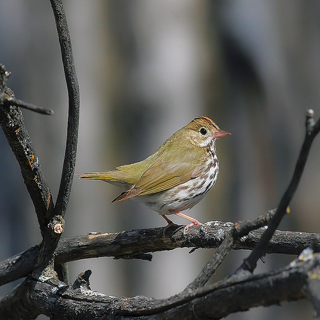

Image:2823 Gt:Ovenbird, 1st Pred:Ovenbird, 8.876, 2nd Pred:Acadian Flycatcher, 3.883


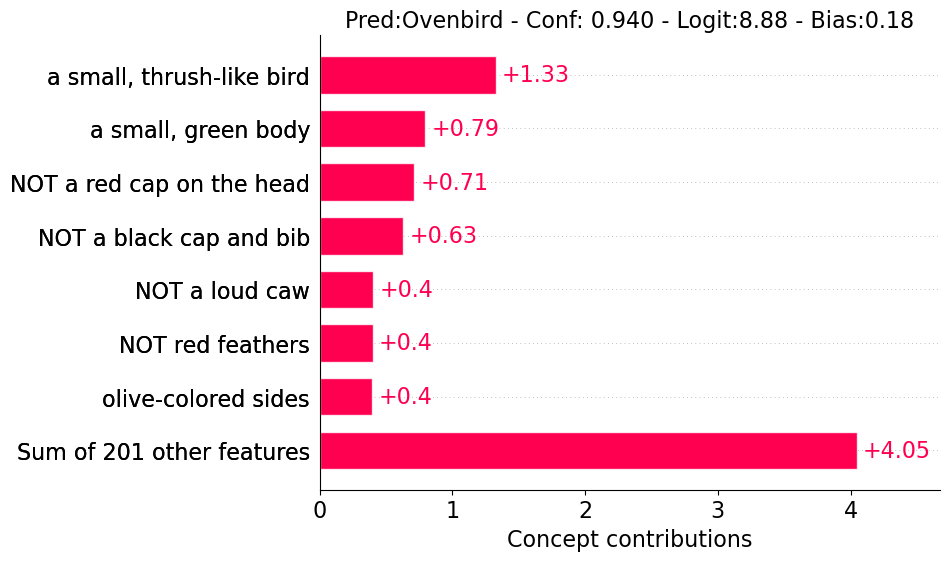

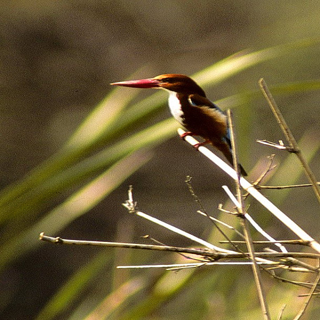

Image:2357 Gt:White breasted Kingfisher, 1st Pred:White breasted Kingfisher, 5.902, 2nd Pred:Anna Hummingbird, 5.144


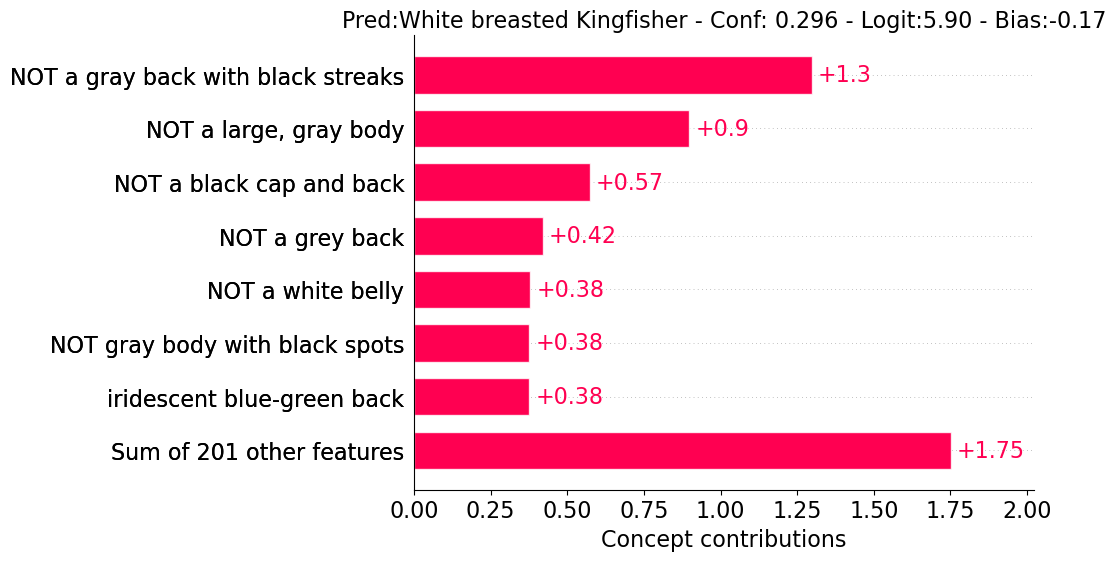

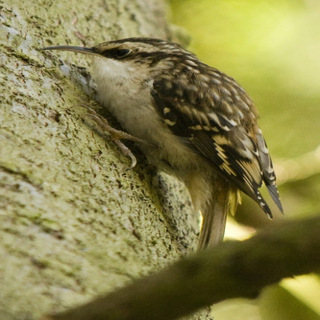

Image:730 Gt:Brown Creeper, 1st Pred:Brown Creeper, 8.903, 2nd Pred:Rock Wren, 4.608


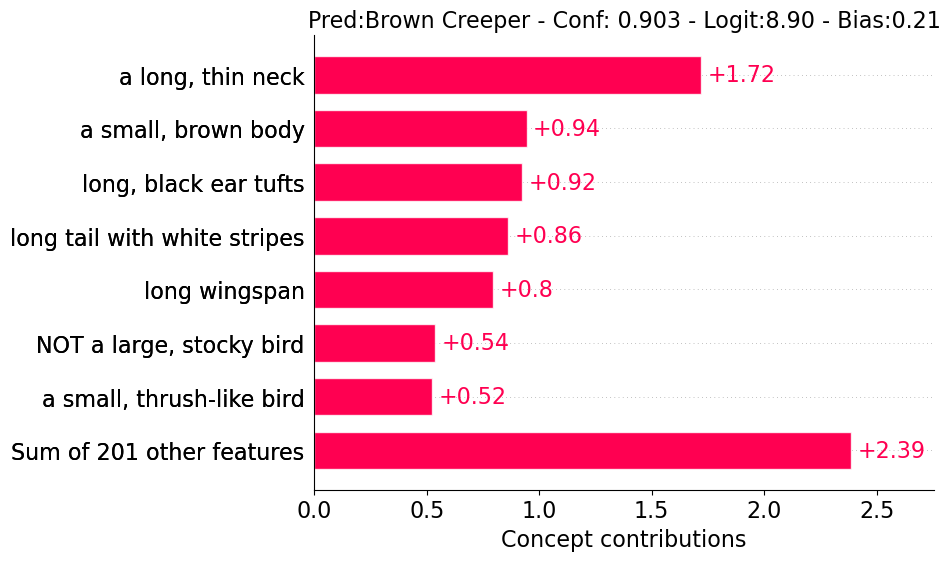

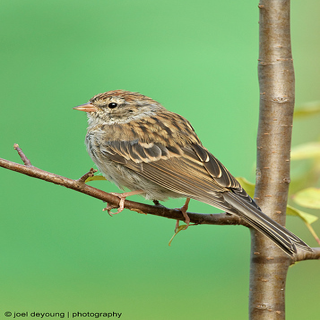

Image:3666 Gt:Song Sparrow, 1st Pred:Field Sparrow, 7.659, 2nd Pred:Clay colored Sparrow, 7.513


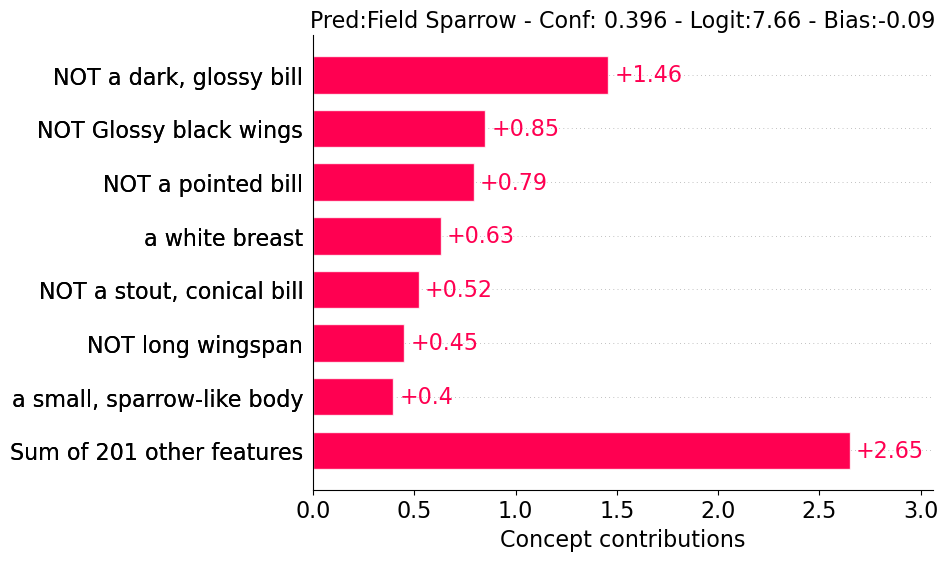

In [14]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)